## Import libraries

In [1]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

client = ESMC.from_pretrained("esmc_600m").to("cuda")

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import torch 

## Dataset GFP

In [4]:
# we can create the dataset:
data_dir = Path("/n/home06/tbush/gfp_function_prediction/data/raw_data")
sequence_path =  data_dir / "P42212.fasta.txt"
original_dataset_path = data_dir / "amino_acid_genotypes_to_brightness.tsv"
# load the dataset
gfp_dataset_original = pd.read_csv(original_dataset_path, sep="\t")

In [5]:
# load utilities functions 
from utils.utils import parse_mutation, mutate_seq, get_numb_mut, load_seq_
def mutate_sequence(mutation_string, seq, mapping_db_seq):
    if pd.isna(mutation_string):
        return None
    try:
        mutations = mutation_string.split(":")
        for m in mutations:
            src, idx, dest = parse_mutation(m)
            if idx in mapping_db_seq:
                mapped_idx = mapping_db_seq[idx]
                mutated_seq = seq[:mapped_idx] + dest + seq[mapped_idx + 1 :]
                return mutated_seq
    except Exception:
        return None
    return None

    # Calculate the original distribution of num_mut
    def get_numb_mut(mut: str) -> int:
        if type(mut) == str:
            n = len(mut.split(":"))
        else:
            return 0
        return n

In [6]:
seq, mapping = load_seq_(sequence_path)
gfp_dataset_original["seq_mutated"] = gfp_dataset_original["aaMutations"].apply(
    lambda muts: mutate_sequence(muts, seq=seq, mapping_db_seq=mapping)
)
gfp_dataset_original["num_mut"] = gfp_dataset_original['aaMutations'].apply(lambda mut: get_numb_mut(mut))

## LLR Metric Computation

In [7]:
# now we load the model + utilities for calculuting the LLR metrics
from esm.sdk.api import ESMProtein, LogitsConfig
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [8]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
client = ESMC.from_pretrained("esmc_600m").to("cuda")
def token_id(x: str, client) -> int:
    enc = client.encode(ESMProtein(x))
    return int(enc.sequence[1])  # BOS at 0, your token at 1, EOS at 2
aa_ids = {a: token_id(a, client=client) for a in amino_acids}
mask_id = token_id("<mask>", client=client)

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [9]:
def generate_heatmap(protein_sequence:str, start_pos:int=1, end_pos=None):

  # load model and tokenizer
  forge_client = ESMC.from_pretrained("esmc_600m").to("cuda")
  aa_ids = {'A': 5,
            'C': 23,
            'D': 13,
            'E': 9,
            'F': 18,
            'G': 6,
            'H': 21,
            'I': 12,
            'K': 15,
            'L': 4,
            'M': 20,
            'N': 17,
            'P': 14,
            'Q': 16,
            'R': 10,
            'S': 8,
            'T': 11,
            'V': 7,
            'W': 22,
            'Y': 19}

  # tokenize the input sequence
  protein = ESMProtein(protein_sequence)
  input_ids = forge_client.encode(protein)
  sequence_length = len(protein_sequence)

  if end_pos is None:
    end_pos = sequence_length

  # list aminoacids
  amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

  #initialize the heatmap
  heatmap = np.zeros((20, end_pos - start_pos + 1))

  # calculate LLRs for each position and aminoacid:
  for position in range(start_pos, end_pos +1):
    # make masked sequence
    i = position -1
    masked_seq = protein_sequence[:i] + "<mask>" + protein_sequence[i+1:]
    protein = ESMProtein(masked_seq)
    enc = forge_client.encode(protein)

    # get per-position logits
    out = forge_client.logits(
    enc, LogitsConfig(sequence=True, return_embeddings=True))

    # identify the masked-token index in logits:
    masked_tok_idx = position
    masked_logits = out.logits.sequence.squeeze()[masked_tok_idx]

    # get log probs:
    log_probs = torch.log(F.softmax(masked_logits, dim=-1))

    # wt residue
    wt_residue = protein_sequence[position-1]
    wt_id = aa_ids[wt_residue]
    log_prob_wt = log_probs[wt_id].item()

    # LLR for the residues
    for i, aa in enumerate(amino_acids):
      mt_id = aa_ids[aa]
      log_prob_mt = log_probs[mt_id].item()
      heatmap[i, position-start_pos] = log_prob_mt - log_prob_wt

  # visualize the heatmap
  plt.figure(figsize=(15, 5))
  plt.imshow(heatmap, cmap="viridis", aspect="auto")
  plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
  plt.yticks(range(20), amino_acids)
  plt.xlabel("Position in Protein Sequence")
  plt.ylabel("Amino Acid Mutations")
  plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
  plt.colorbar(label="Log Likelihood Ratio (LLR)")
  plt.show()
  return heatmap


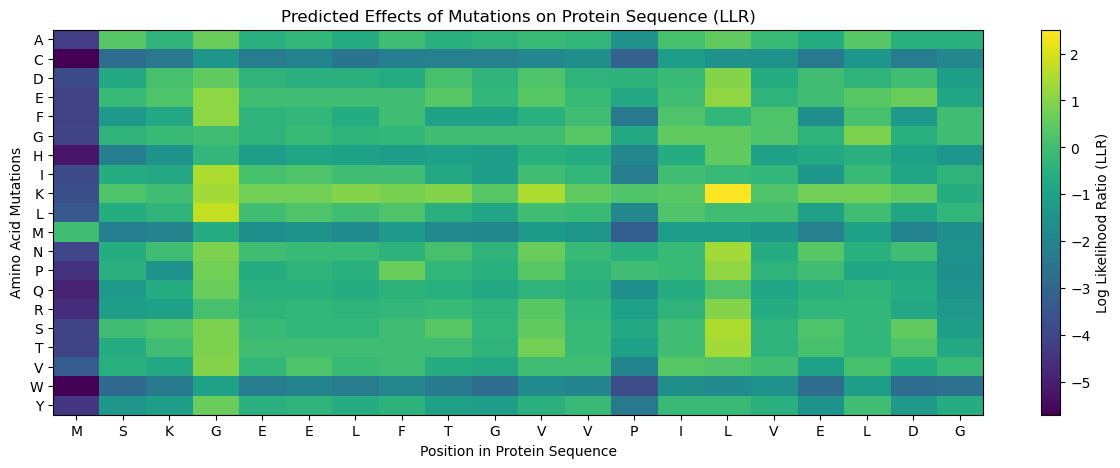

In [10]:
heatmap = generate_heatmap(seq, end_pos=20)

### Function to get embedding and P of a mutated sequence:

In [11]:
def get_embedding(sequence:str, client:ESMC):
    protein = ESMProtein(sequence)
    enc = client.encode(protein)
    out = client.logits(
        enc, LogitsConfig(sequence=True, return_embeddings=True))
    return out.logits.sequence, out.embeddings 

In [12]:
embeddings, logits = get_embedding(seq, client)

### Try to predict the function

In [57]:
# funciton to get embeddings in batch:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Sequence, Tuple, List, Any, Union
from tqdm.auto import tqdm
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

def embed_sequence(client: ESMC, sequence: Union[str, ESMProtein]):
    """Return (logits, embeddings) on CPU. Shapes: (1, L, V), (1, L, D)."""
    protein = sequence if isinstance(sequence, ESMProtein) else ESMProtein(sequence)
    enc = client.encode(protein)
    out = client.logits(enc, LogitsConfig(sequence=True, return_embeddings=True))
    # move to CPU to avoid GPU-memory blowup and ensure cat compatibility
    return out.logits.sequence.detach().to("cpu"), out.embeddings.detach().to("cpu")

# --- batch wrapper (threaded; set max_workers=1 for safest CUDA use) ---
def batch_embed(
    client: ESMC,
    inputs: Sequence[Union[str, ESMProtein]],
    max_workers: int = 1,   # GPU models are often not thread-safe; 1 is safest
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """
    Runs embed_sequence for each input. Preserves order, returns lists of tensors.
    """
    n = len(inputs)
    logits:     List[Any] = [None] * n
    embeddings: List[Any] = [None] * n

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(embed_sequence, client, seq): i for i, seq in enumerate(inputs)}
        for fut in tqdm(as_completed(futures), total=n, desc="Embedding"):
            i = futures[fut]
            try:
                logit, emb = fut.result()
                logits[i] = logit
                embeddings[i] = emb
            except Exception as e:
                logits[i] = e
                embeddings[i] = e

    # check for errors
    errors = [(i, x) for i, x in enumerate(logits) if isinstance(x, Exception)]
    if errors:
        msgs = "\n".join([f"  idx {i}: {err}" for i, err in errors])
        raise RuntimeError(f"{len(errors)} sequences failed:\n{msgs}")

    # type narrowing
    logits = [t for t in logits if isinstance(t, torch.Tensor)]
    embeddings = [t for t in embeddings if isinstance(t, torch.Tensor)]
    return logits, embeddings

# --- dataset helper ---
def create_dataset(df: pd.DataFrame, n: int, client: ESMC):
    """
    Samples n rows, embeds seq_mutated strings.
    Returns:
      logits_b:     Tensor (N, L, V)
      embeddings_b: Tensor (N, L, D)
      labels_t:     Tensor (N,)
    """
    sampled_df = df.sample(n)  # add random_state=... for reproducibility
    inputs = sampled_df["seq_mutated"].tolist()  # keep as strings
    labels = sampled_df["Class"].tolist()

    logits_list, emb_list = batch_embed(client, inputs, max_workers=1)

    # sanity: all lengths equal
    lengths = [t.shape[1] for t in logits_list]
    if len(set(lengths)) != 1:
        raise ValueError(f"Sequences have different lengths: {set(lengths)}; "
                         "cannot concatenate without padding.")

    # concatenate along the batch dimension (dim=0)
    logits_b = torch.cat(logits_list, dim=0)       # (N, L, V)
    embeddings_b = torch.cat(emb_list, dim=0)      # (N, L, D)
    labels_t = torch.as_tensor(labels)

    return logits_b, embeddings_b, labels_t


In [58]:
# create labels for GoF and LoF: 2.6 is the mean, median 3.2
gfp_dataset_original["Class"] = gfp_dataset_original["medianBrightness"].apply(lambda x: 0 if x <= 2.6 else 1 )

In [60]:
logits, embeddings, labels = create_dataset(gfp_dataset_original, 10, client)

Embedding:   0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
# now let's create a dataset with Pytorch + model
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, n:int, client):
        logits, embeddings, labels = create_dataset(gfp_dataset_original, n, client)
        self.features = embeddings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        embedding = self.features[index]
        label = self.labels[index]
        return embedding, label

In [69]:
dataset = CustomDataset(gfp_dataset_original, 10, client)

Embedding:   0%|          | 0/10 [00:00<?, ?it/s]